In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from lightgbm import plot_importance
import joblib
from hnmchallenge.constant import *
from hnmchallenge.data_reader import DataReader

from hnmchallenge.evaluation.python_evaluation import map_at_k, recall_at_k
from hnmchallenge.feature_manager import FeatureManager
from hnmchallenge.datasets.last_week_last_week import LWLWDataset
from hnmchallenge.datasets.last_month_last_week_dataset import LMLWDataset
from hnmchallenge.datasets.last_month_last_day import LMLDDataset
from hnmchallenge.models.itemknn.itemknn import ItemKNN
import lightgbm as lgb


/raid/home/edoardo/GitProjects/HnMChallenge/.venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
dataset = LMLDDataset()
dr = DataReader()

In [3]:
base_load_path = dataset._DATASET_PATH / "lgbm_models"

In [4]:
VERSION = 0
NAME = "cutf_200_ItemKNN_tw_True_rs_False"
DATASET = f"{NAME}_{VERSION}.feather"
MODEL_NAME = f"lgbm_{DATASET}.pkl"

In [5]:
model=joblib.load(base_load_path/MODEL_NAME)

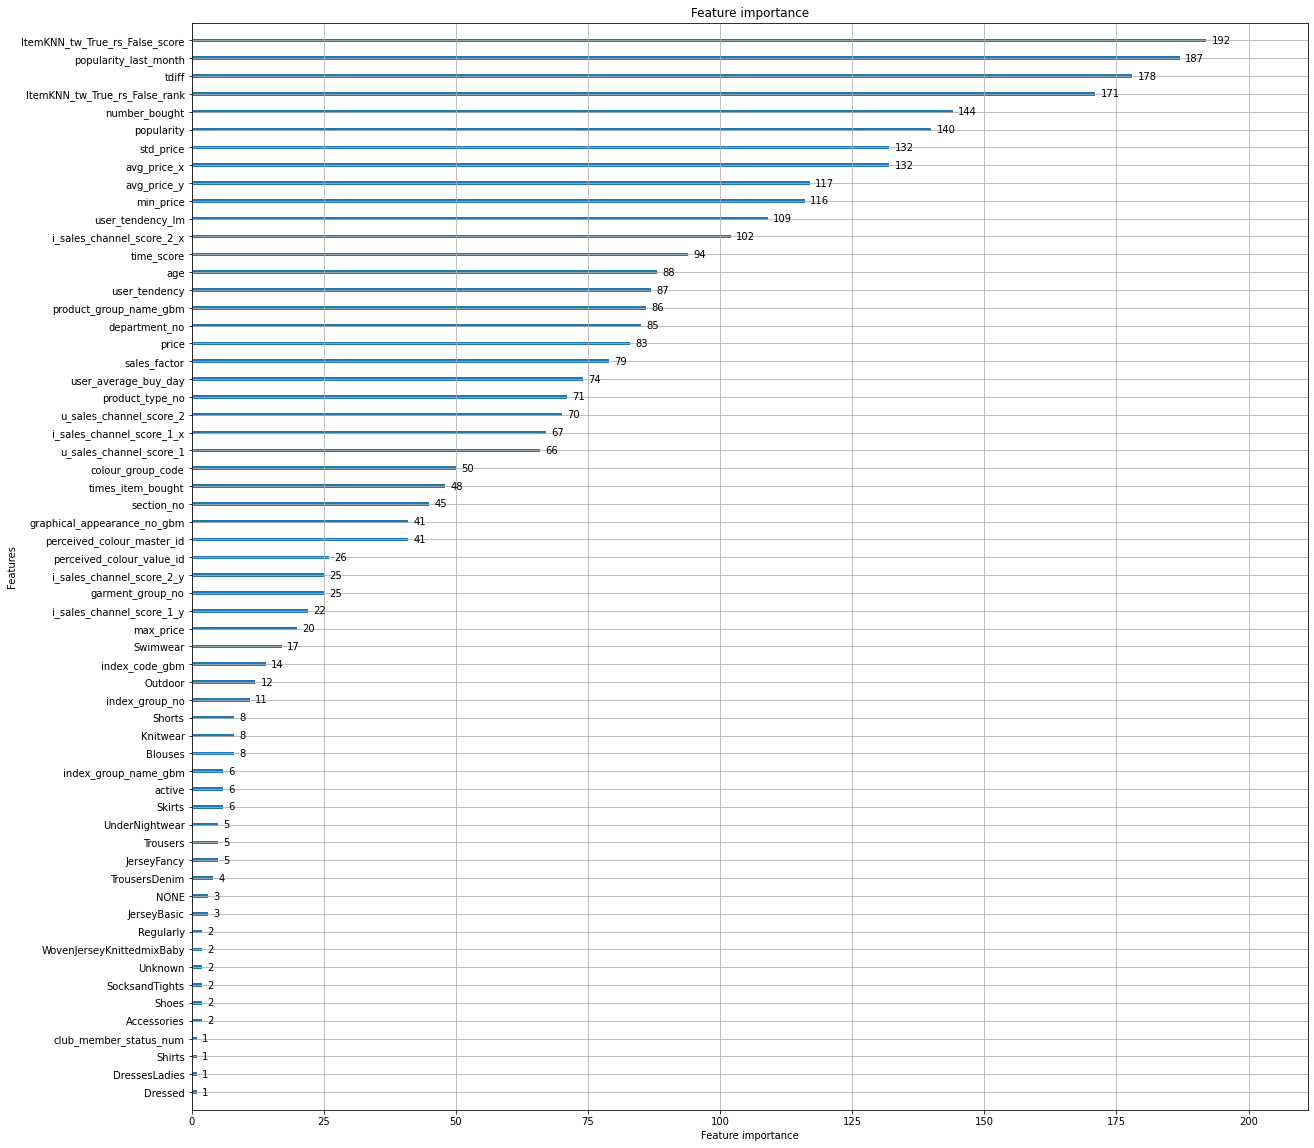

In [6]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_importance(model, ax=ax)
plt.show()

In [7]:
model.best_iteration_

105

In [ ]:
import re
features = pd.read_feather(dataset._DATASET_PATH / f"dataset_dfs/full/{DATASET}")
features = features.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))

# Remember to use the bert_ntree_limit when taking the predictions

In [ ]:
features.head()

In [ ]:
features.columns

In [ ]:
cat = [
    "index_code_gbm",
    "product_group_name_gbm",
    "index_group_name_gbm",
    "graphical_appearance_no_gbm",
]

cat_index = [i for i, c in enumerate(features.columns) if c in cat]
print(cat_index)

for col in cat:
    features[col] = pd.Categorical(features[col])

In [ ]:
customer_article_df = features[[DEFAULT_USER_COL, DEFAULT_ITEM_COL]].copy()
X = features.drop([DEFAULT_USER_COL, DEFAULT_ITEM_COL], axis=1)

In [ ]:
y_pred = model.predict(X, num_iteration=model.best_iteration_)

In [ ]:
customer_article_df["predicted_score"] = y_pred

In [ ]:
customer_article_df

In [ ]:
sorted_scores = customer_article_df.sort_values([DEFAULT_USER_COL, "predicted_score"], ascending=[True, False])

In [ ]:
sorted_scores.head(20)

In [ ]:
sorted_scores_index = sorted_scores.reset_index(drop=True)

In [ ]:
cutoff = sorted_scores_index.groupby(DEFAULT_USER_COL).size().values
i=0 
filter_indices = []
for cut in cutoff:
    filter_indices.extend(range(i, i+12))
    i=i+cut

In [ ]:
cutoff.mean()

In [ ]:
filter_indices

In [ ]:
final_df = sorted_scores_index.loc[filter_indices]

In [ ]:
final_df

In [ ]:
final_final_df = final_df.drop("predicted_score", axis=1)

In [ ]:
dataset.create_submission(final_final_df, sub_name="gbm_iknn_200")